Suppress all warnings

In [357]:
import warnings
warnings.filterwarnings("ignore")

Import basic libraries

In [358]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns

In [359]:
# To output/print multiple things from a single cell

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [360]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score

In [361]:
# specify which certain GPUs are in use (before import tensorflow)
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [362]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Load Train/Test Data

In [363]:
train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')

In [364]:
train.shape
test.shape

(60000, 785)

(10000, 785)

In [365]:
train.head()
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [366]:
# Separate out features and target

X_train = train.copy()
y_train = train['label']
X_train.drop('label', axis=1, inplace=True)

X_test = test.copy()
y_test = test['label']
X_test.drop('label', axis=1, inplace=True)

<b> Plot class counts for target</b>

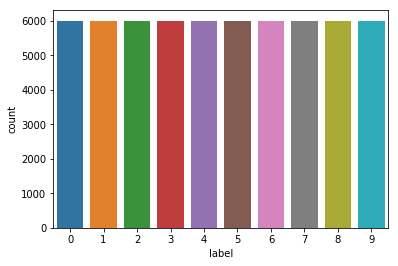

In [367]:
_ = sns.countplot(y_train)

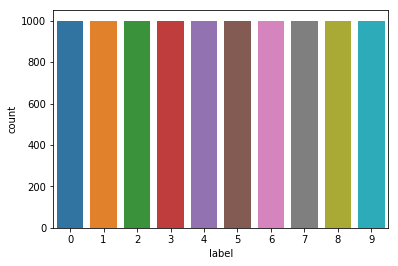

In [368]:
_ = sns.countplot(y_test)

<b>Plot a target image</b>

In [369]:
def plot_item(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

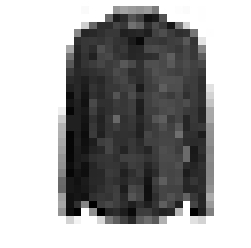

In [370]:
plot_item(np.array(X_train.iloc[2]))

<b>Plot multiple target images</b>

In [371]:
def plot_items(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=matplotlib.cm.binary, **options)
    plt.axis("off")

<Figure size 1080x1080 with 0 Axes>

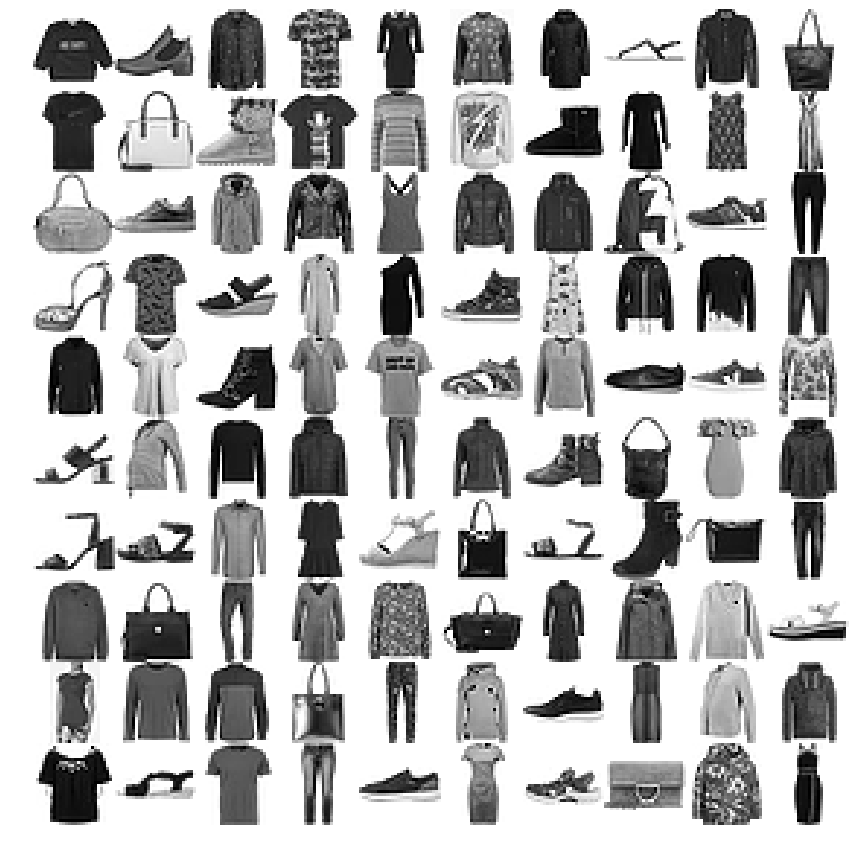

In [372]:
plt.figure(figsize=(15,15))
example_images = np.array(X_train.iloc[:100])
plot_items(example_images, images_per_row=10)
#save_fig("more_items_plot")
plt.show()

<b>Normalize the gray scale pixel values between 0-1</b>

In [373]:
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0

<b>Re-shape the train/test inputs to the format (samples, height, width, channels) for the DL model</b>

In [374]:
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

<b>One-hot encode categorical target values</b>

In [375]:
from keras.utils import to_categorical
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)

## Define the model

In [376]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', padding = 'Same', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (5,5), padding = 'Same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding = 'Same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding = 'Same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='softmax')    
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [377]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 7, 7, 64)          0         
__________

In [378]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator()

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train_enc, batch_size=32)
val_generator = val_datagen.flow(X_test, y_test_enc, batch_size=32)

In [379]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_acc') >= 0.9970):
            print("\nReached 99.70% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

In [380]:
# callbacks_list = [
#     tf.keras.callbacks.EarlyStopping(monitor='acc', patience=1),
# ]

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(filepath='my_model.h5', monitor='val_loss', save_best_only=True)
]

In [381]:
# model fitting
history = model.fit_generator(train_generator,
                              epochs=10,
                              verbose=1,
                              validation_data=val_generator, callbacks=callbacks_list)

# 93.88

Epoch 1/10
1875/1875 [==============================] - 63s 34ms/step - loss: 0.4594 - acc: 0.8327 - val_loss: 0.2842 - val_acc: 0.8946
Epoch 2/10
1875/1875 [==============================] - 42s 23ms/step - loss: 0.2994 - acc: 0.8907 - val_loss: 0.2430 - val_acc: 0.9060
Epoch 3/10
1875/1875 [==============================] - 44s 24ms/step - loss: 0.2608 - acc: 0.9046 - val_loss: 0.2147 - val_acc: 0.9205
Epoch 4/10
1875/1875 [==============================] - 44s 23ms/step - loss: 0.2379 - acc: 0.9132 - val_loss: 0.2177 - val_acc: 0.9176
Epoch 5/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.2230 - acc: 0.9177 - val_loss: 0.1991 - val_acc: 0.9250
Epoch 6/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.2090 - acc: 0.9229 - val_loss: 0.2041 - val_acc: 0.9231
Epoch 7/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.1999 - acc: 0.9259 - val_loss: 0.1891 - val_acc: 0.9290
Epoch 8/10
1875/1875 [==========================

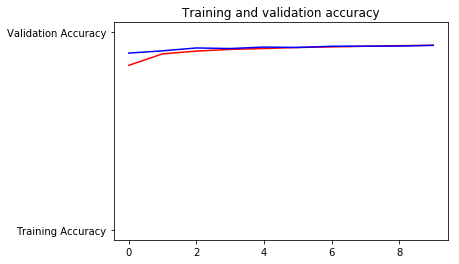

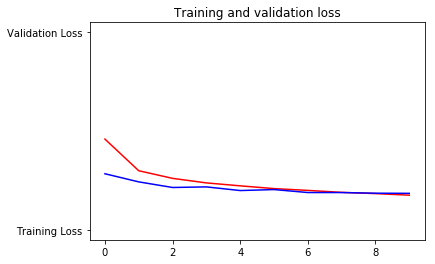

In [382]:
# PLOT LOSS AND ACCURACY
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
_ = plt.plot(epochs, acc, 'r', "Training Accuracy")
_ = plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
_ = plt.title('Training and validation accuracy')
_ = plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
_ = plt.plot(epochs, loss, 'r', "Training Loss")
_ = plt.plot(epochs, val_loss, 'b', "Validation Loss")


_ = plt.title('Training and validation loss')

In [383]:
predictions = model.predict(X_test)
print('predictions shape:', predictions.shape)

predictions shape: (10000, 10)


In [384]:
y_pred = []
for x in predictions:
    y_pred.append(np.argmax(x))

In [385]:
y_pred[:5]
y_test[:5]

[0, 1, 2, 2, 3]

0    0
1    1
2    2
3    2
4    3
Name: label, dtype: int64

In [386]:
accuracy_score(y_test, y_pred)

0.9336

In [387]:
from sklearn.metrics import confusion_matrix

In [388]:
conf_mx = confusion_matrix(y_test, y_pred)
conf_mx

array([[864,   1,  27,   8,   0,   0,  98,   0,   2,   0],
       [  0, 994,   1,   2,   0,   0,   3,   0,   0,   0],
       [  9,   0, 894,  10,  45,   0,  42,   0,   0,   0],
       [  7,   7,   6, 936,  22,   0,  21,   0,   1,   0],
       [  0,   0,  26,  10, 923,   0,  40,   0,   1,   0],
       [  0,   0,   0,   0,   0, 966,   0,  25,   3,   6],
       [ 68,   0,  45,  19,  53,   0, 815,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 986,   0,  14],
       [  1,   1,   1,   0,   1,   0,   6,   0, 989,   1],
       [  0,   0,   0,   0,   0,   0,   0,  30,   1, 969]])

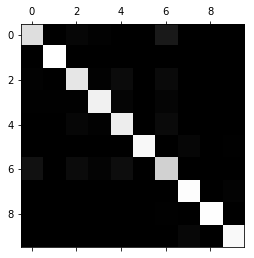

In [389]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [390]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

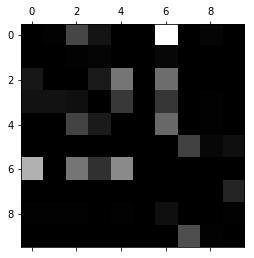

In [391]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [392]:
'''
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot
'''

'\n0 T-shirt/top\n1 Trouser\n2 Pullover\n3 Dress\n4 Coat\n5 Sandal\n6 Shirt\n7 Sneaker\n8 Bag\n9 Ankle boot\n'